Dans ce notebook, nous allons nous intéresser aux variational autoencoders. Dans le notebook précédent (Plus loin avec les autoencoders), nous avons vu que les autoencoders permettaient de comprimer les images et qu'ils pouvaient être utiliser pour enlever du bruit dans les images. Par contre ils ne sont pas capables de générer de nouvelles images. Dans un premier temps nous verrons pourquoi puis nous présenterons les variational autoencoder qui sont des modèles générateurs : ils peuvent être utilisés pour générer des images.

## Installation



Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :  

*! pip install nom_librairie*  

**Attention :** il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.

**Remarque :** même si toutes les librairies sont importées dès le début, les librairies utiles pour des fonctions présentées au cours de ce notebook sont ré-importées de manière à indiquer d'où elles viennent et ainsi faciliter la réutilisation de la fonction dans un autre projet.



In [ ]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...

# sous Colab il faut déjà intégrer ces deux librairies

#!pip install nom_librairie

# eventuellement ne pas oublier de relancer le kernel du notebook

In [1]:
# Importation des différentes librairies utiles pour le notebook
#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle
import pandas as pd
from scipy.stats import randint
import numpy as np
from numpy import mean, std
import string
import os
from os import listdir
from os.path import isfile, join
import time
import base64
import re
import sys
import copy
import random
import datetime
import glob
from glob import glob
import cv2
import zipfile

# librairie affichage
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow et keras
import tensorflow as tf
from tensorflow.keras.losses import mse
import tensorflow._api.v2.compat.v1 as tf
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import LeakyReLU
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.layers import InputLayer, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.utils import plot_model





Pour pouvoir sauvegarder sur votre répertoire Google Drive, il est nécessaire de fournir une autorisation. Pour cela il suffit d'éxecuter la ligne suivante et de saisir le code donné par Google.

In [2]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Corriger éventuellement la ligne ci-dessous pour mettre le chemin vers un répertoire spécifique dans votre répertoire Google Drive :

In [3]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024'

# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd


/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024


'/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024'

####Le jeu de données et le modèle d'autoencoder


**Utilisation du jeu de données et du modèle de l'autoencoder**

Dans cette section, nous reprenons le même jeu de données que pour le notebook "Aller plus loin avec les autoencoders". Nous utilisons également le même modèle qui contient un encoder et un decoder. Comme nous avons utilisé ce modèle pour des tâches différentes : compression et suppression de bruits. Par la suite, nous récupérons le modèle utilisé pour la compression.   


Si vous n'avez pas récupéré le jeu de données et les poids, il est possible de les télécharger : pour cela, il suffira de décommenter les cellules.



Décommenter la cellule suivante pour récupérer l'ensemble des données.

In [4]:
#!wget https://www.lirmm.fr/~poncelet/Ressources/Humans2.zip

--2023-09-07 21:29:06--  https://www.lirmm.fr/~poncelet/Ressources/Humans2.zip
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1955253165 (1.8G) [application/zip]
Saving to: ‘Humans2.zip’

Humans2.zip         100%[===================>]   1.82G  18.9MB/s    in 1m 41s  

2023-09-07 21:31:07 (18.5 MB/s) - ‘Humans2.zip’ saved [1955253165/1955253165]



Décommenter la cellule suivante pour dezipper le fichier de données :    

In [5]:
# Unzip the file. It must create a Humans2 directory with a subdirectory train
#getzip = zipfile.ZipFile('Humans2.zip')
#getzip.extractall()

Décommenter la cellule suivante pour récupérer les poids du modèle appris :

In [6]:
!wget https://www.lirmm.fr/~poncelet/Ressources/AEweights.h5

--2023-09-07 21:32:51--  https://www.lirmm.fr/~poncelet/Ressources/AEweights.h5
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7353944 (7.0M) [text/plain]
Saving to: ‘AEweights.h5’

AEweights.h5        100%[===================>]   7.01M  4.75MB/s    in 1.5s    

2023-09-07 21:32:54 (4.75 MB/s) - ‘AEweights.h5’ saved [7353944/7353944]



Nous chargeons les poids du modèle :

In [7]:
DATA_FOLDER = "Humans2"
NUM_IMAGES=len(os.listdir(DATA_FOLDER))
EPOCH=25
WEIGHTS_FOLDER = './myweights/'

# Get all the file names with extension .jpg from DATA_FOLDER/train
filenames = np.array(glob(os.path.join(DATA_FOLDER+'/train', '*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 256
Z_DIM = 200 # Dimension of the latent vector

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER,
                                                                  classes=['train'],
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   #color_mode='rgb',
                                                                   seed=42,
                                                                   class_mode = 'input'
                                                                   )

Total number of images : 6973
Found 7219 images belonging to 1 classes.


Le modèle de l'autoencoder : d'abord la partie encoder puis la partie décoder. Le modèle de l'autoencoder est exactement le même pour l'instant que celui du notebook "Plus loin avec les autoencoders".   

Partie encoder

In [8]:
# ENCODER
def build_encoder(input_dim, output_dim):
  # By using clear_session we remove all the previous runs. That's a way to re-initialize
  global K
  K.clear_session()

  #  model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # First convolution
  x= Conv2D(filters = 32,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'encoder_conv_1')(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Second Convolution
  x= Conv2D(filters = 64,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'encoder_conv_2')(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Third Convolution
  x= Conv2D(filters = 64,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'encoder_conv_3')(x)
  # Applying the activation function
  x = LeakyReLU()(x)

   # Fourth Convolution
  x= Conv2D(filters = 64,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'encoder_conv_4')(x)
  # Applying the activation function
  x = LeakyReLU()(x)


  # We need to get the latest shape before applying flatten for the decoder
  shape_before_flattening = K.int_shape(x)[1:]

  # Flatten the last CNN
  x = Flatten()(x)

  # Define the model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

Création de l'encoder :

In [9]:
encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM,
                                    )

Partie decoder :

In [10]:
# DECODER

def build_decoder(input_dim, shape_before_flattening):
  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # First Conv2DTranspose layer
  x = Conv2DTranspose(filters = 64,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'decoder_conv_1'
                  )(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Second Conv2DTranspose layer
  x = Conv2DTranspose(filters = 64,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'decoder_conv_2'
                  )(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Third Conv2DTranspose layer
  x = Conv2DTranspose(filters = 32,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'decoder_conv_3'
                  )(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Fouth Conv2DTranspose layer
  x = Conv2DTranspose(filters = 3,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'decoder_conv_4'
                  )(x)
  # Applying the activation function
  x = Activation('sigmoid')(x)

  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

Creation du decoder :

In [11]:
decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening
                                        )

Creation de l'autoencoder :

In [12]:
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder_output)
autoencoder = Model(autoencoder_input, autoencoder_output)

Chargement des poids du modèle appris :

In [13]:
autoencoder.load_weights('AEweights.h5')

Rappel de la visualisation des résulats :

In [14]:
def show_images(autoencoder, images=None):
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  reconst_images = autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

1/1 [==============================] - 9s 9s/step


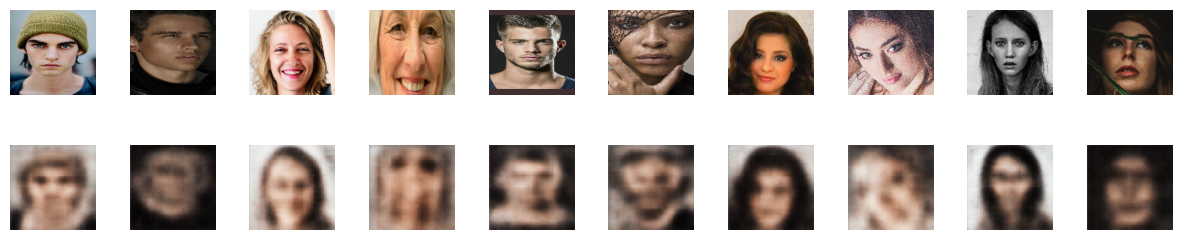

In [15]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]
show_images(autoencoder,example_images)

A présent, nous allons nous intéresser à ce qui se passe dans le latent space. Par rapport à la dernière partie, nous avons un batchsize plus grand.

8/8 [==============================] - 0s 8ms/step


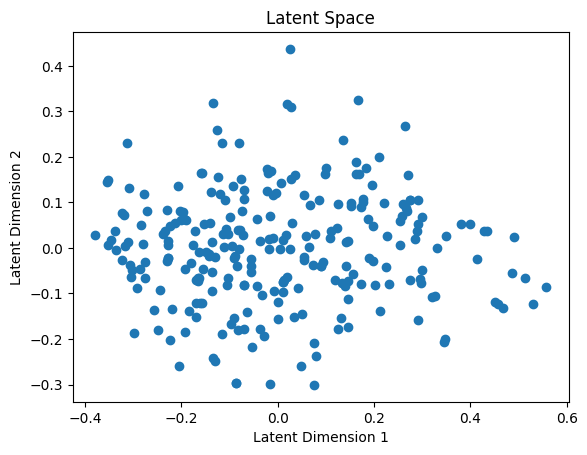

In [16]:
# Create a separate encoder
input_encoder, output_encoder,  _, encoder_model  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM,
                                    )
#encoder_input, encoder_output, _, encoder_model = build_encoder(input_dim, output_dim)
# Create a batch as X_test
X_test = next(data_flow)
# Get the corrupted image
X_test = X_test[0]

# Get the latent space
latent_codes = encoder_model.predict(X_test)

# Use PCA to get the 2 main components
pca = PCA(n_components=2)
latent_codes_2d = pca.fit_transform(latent_codes)

# Plot the latent space
plt.scatter(latent_codes_2d[:, 0], latent_codes_2d[:, 1])
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space')
plt.show()
latent_codes_2d = pca.fit_transform(latent_codes)

Nous pouvons afficher les images pour voir où elles se situent dans le latent space. Par exemple ici nous utilisons TSNE qui est une autre approche de réduction de dimensions.

In [17]:
def plot_tsne_with_images(X_test, image_size=(128, 128), perplexity=30, n_iter=1000, random_state=42):
    # Apply t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=random_state)
    X_tsne = tsne.fit_transform(X_test.reshape(X_test.shape[0], -1)) # Flatten image dimensions into a single dimension

    # Get minimum and maximum values of t-SNE coordinates
    x_min, x_max = X_tsne[:, 0].min(), X_tsne[:, 0].max()
    y_min, y_max = X_tsne[:, 1].min(), X_tsne[:, 1].max()

    # Calculate figure and axes size based on image size
    fig_width, fig_height = (x_max - x_min) * 1.2, (y_max - y_min) * 1.2
    ax_width, ax_height = fig_width / image_size[1], fig_height / image_size[0]

    # Create a figure to display the images
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Iterate through t-SNE points and display images instead of points
    for i in range(X_tsne.shape[0]):
        x = X_tsne[i, 0]
        y = X_tsne[i, 1]
        img = X_test[i]
        ax.imshow(img, cmap='gray', extent=(x - ax_width / 2, x + ax_width / 2, y - ax_height / 2, y + ax_height / 2), origin='upper')
        ax.axis('off')

    # Display the t-SNE visualization
    plt.show()

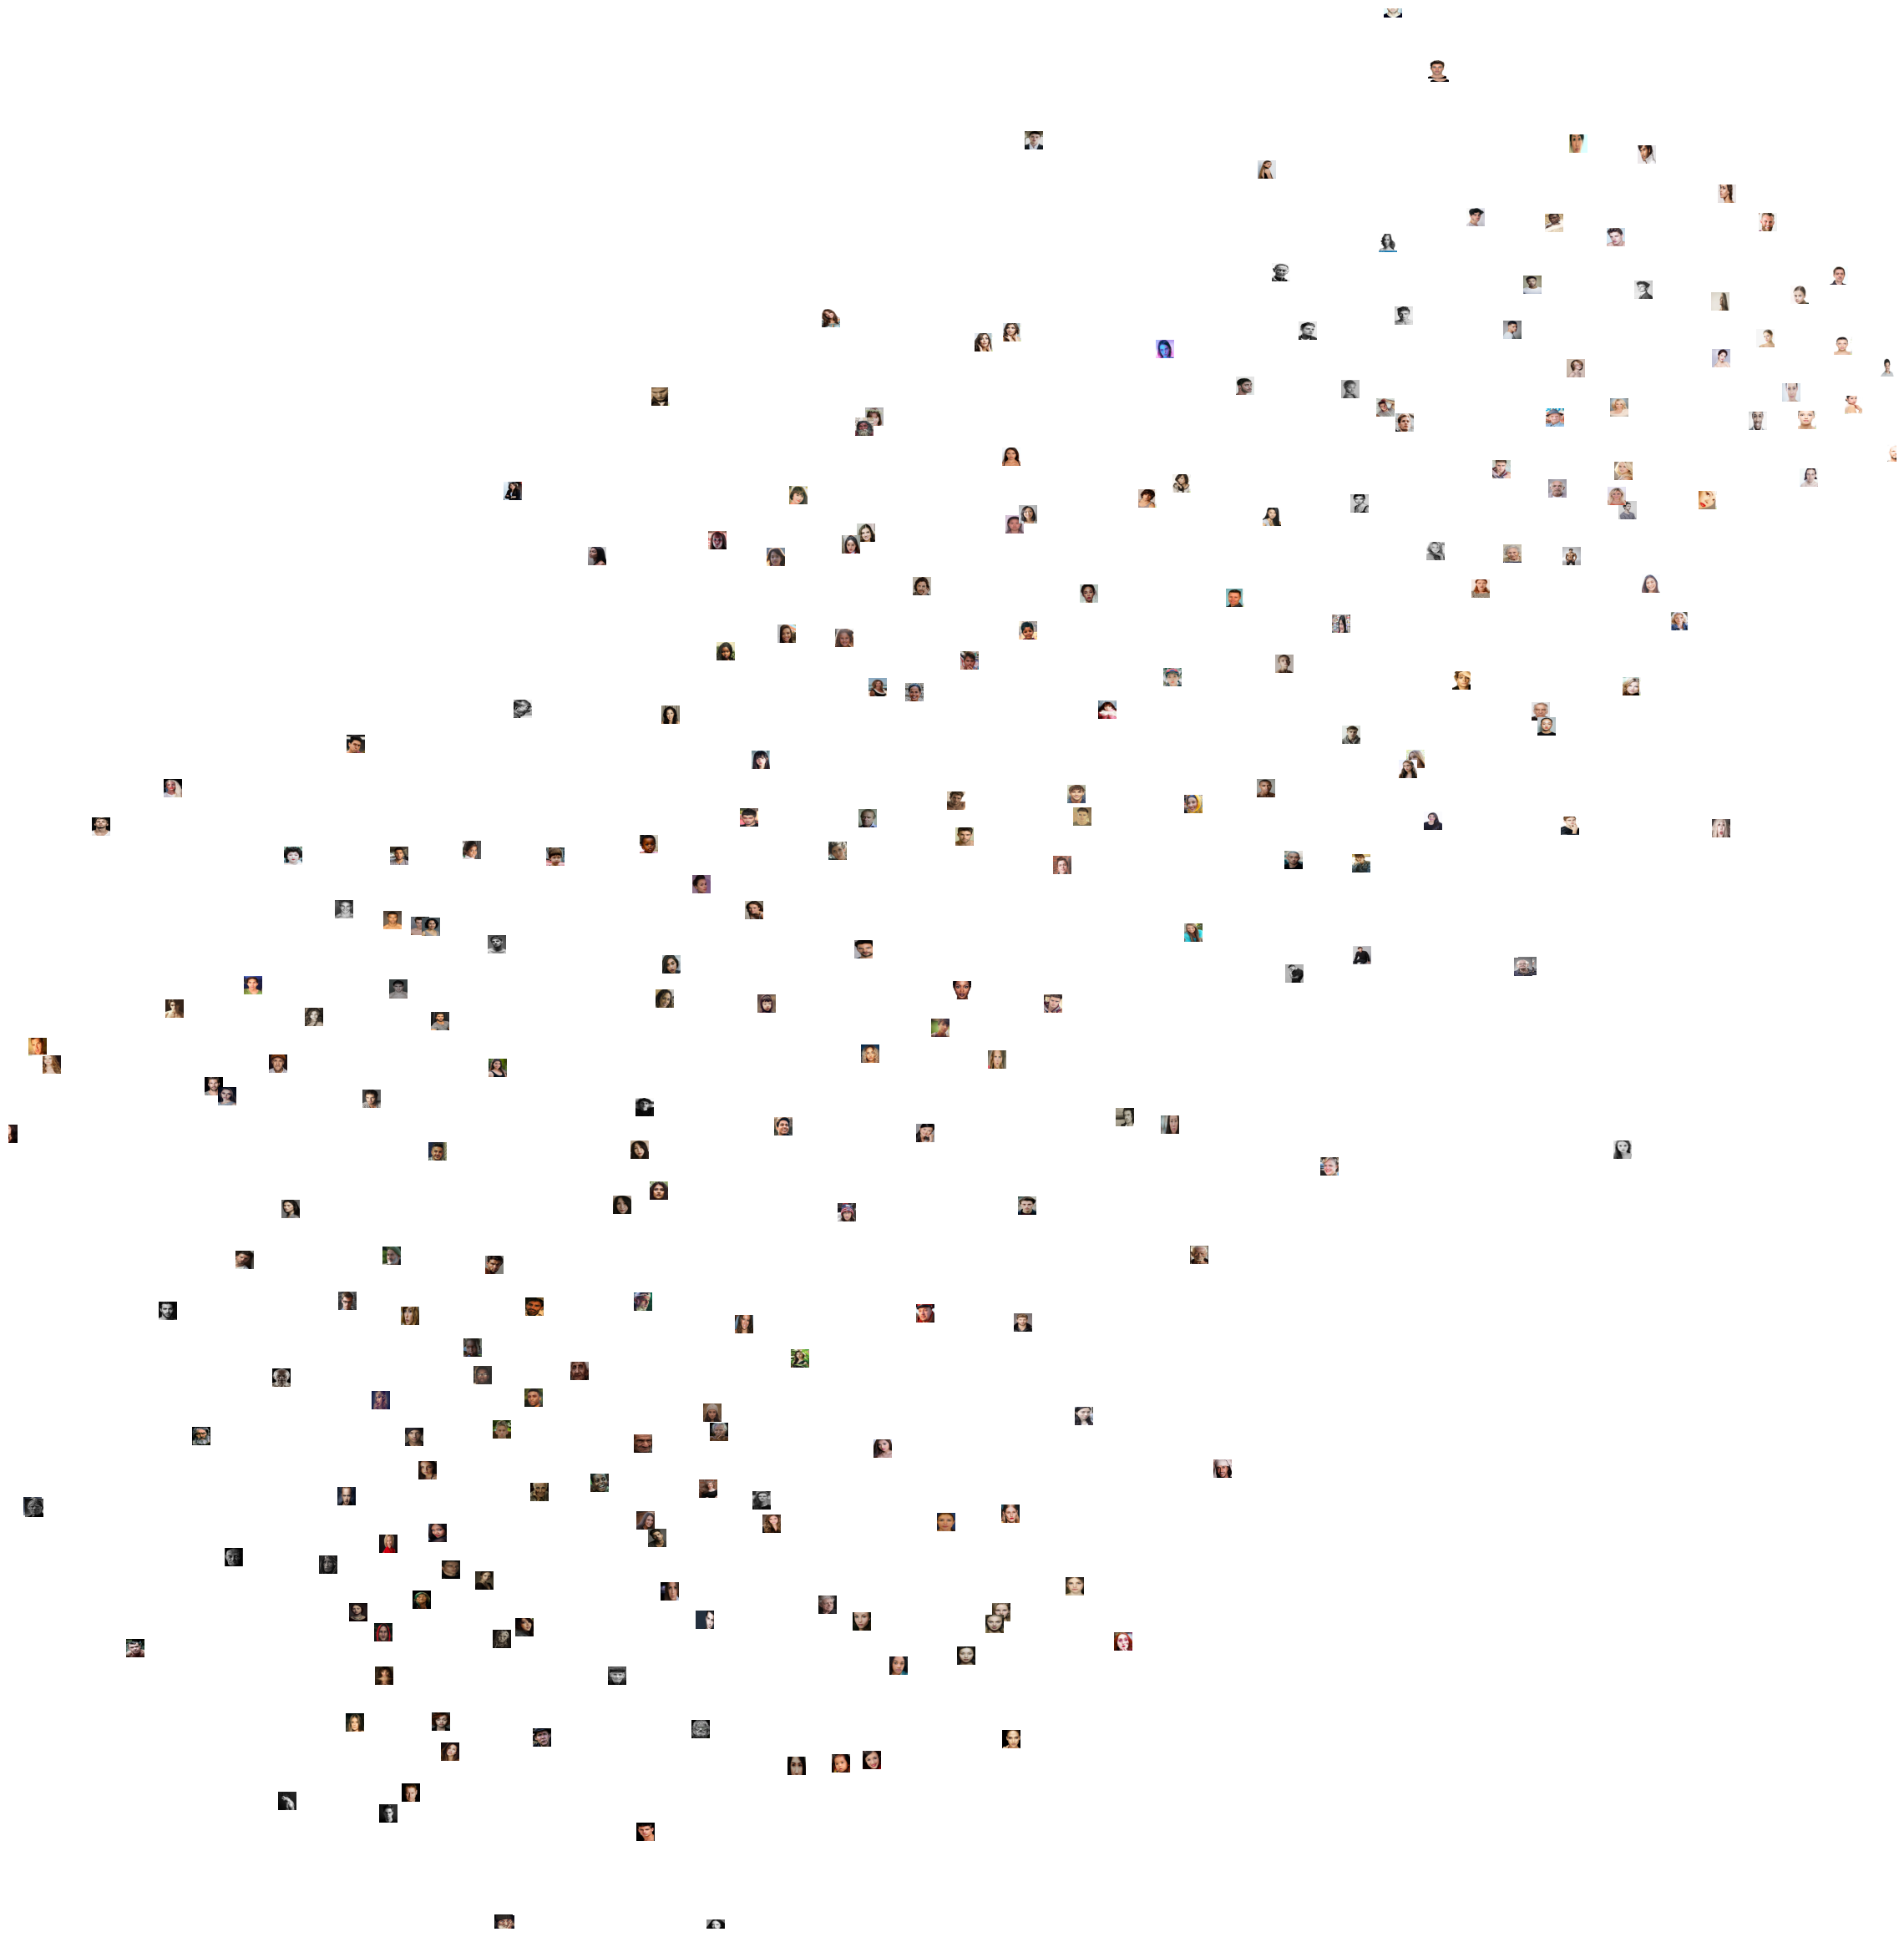

In [18]:
plot_tsne_with_images(X_test)

Si nous regardons attentivement les images (attention cela dépend des données du batch) nous pourrons constater que certaines images qui devraient être proches sont en fait assez éloignées dans le latent space. Considérons à présent les deux images suivantes. La première est issue de https://www.kaggle.com/code/nathra/fashion-mnist-convolutional-autoencoder et la seconde de https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df.  

Elles appliquent le même principe mais réciproquement pour MNIST Fashion et pour MNIST. Pour MNIST Fashion nous pouvons constater que beaucoup de sacs, même s'il existe un cluster, se retrouvent très proches des vêtements. Pour MNIST, si nous regardons les 2 par exemple, nous constatons qu'en fonction de la manière de l'écrire il se répartit dans plusieurs endroits dont certains très lointain. **Ce qu'il faut retenir** c'est que même si c'est un 2 avec ses courbes, les différentes images peuvent être positionnés très loins les unes des autres. En outre, alors que le 2 possède des courbes, il peut être proches d'images qui n'en ont pas : "la manière dont les deux sont formés a une forte influence".

<IMG SRC="http://www.lirmm.fr/~poncelet/Ressources/MnistFashionAutoencoderKaggle.png" align="center" width="500" height="500">


<IMG SRC="http://www.lirmm.fr/~poncelet/Ressources/MnistNumberAutoencoderHackernoon.png" align="center" width="500" height="500">



Il est important de rappeler que les autoencoders sont utilisés pour comprimer les données. Bien entendu nous avons vu que cette compression pouvait être utilisée pour enlever du bruit. Elle peut même par exemple être utilisées pour faire des "Deepfakes" (voir . Par exemple, si j'ai un autoencoder pour Tom Cruise et un pour Gérard Depardieu, je peux très bien utiliser l'encoder de Tom Cruise et le decoder de Gérard Depardieu pour générer une image de Tom Cruise avec des caractéristiques de Gérard Depardieu. C'est le principe général utilisé par des sites comme https://archive.org/details/github.com-aerophile-awesome-deepfakes_-_2020-03-27_06-52-56

<IMG SRC="http://www.lirmm.fr/~poncelet/Ressources/cruisedepardieu.png" align="center" width="600" height="400">

**Quid de la génération?** Les autoencoders ont de nombreuses applications. Ici nous avons vu sur les images mais ils peuvent aussi être utilisés pour la traduction de texte. Mais est-il possible de générer de nouvelles images à partir des autoencoders ?   

En fait pour générer une image, il faut échantilloner le latent space à partir d'une distribution normale. En d'autres termes, comme le latent space représente les images d'origines compressées, nous tirons un vecteur aléatoire en respectant une distribution normale (le fait de prendre une distribution normale permet de localiser une zone du latent space que nous espérons continue) et d'appliquer le decoder sur cet échantillon.

**Pourquoi une distribution normale ?** tous simplement car nous espérons, par exemple, que tous les 2, quelque soit leur variabilité, se retrouvent dans la même zone et qu'en prenant un échantillon dans cette zone nous puissions générer quelque chose qui ressemble à un 2 comme l'illustre la figure suivante.   

<IMG SRC="http://www.lirmm.fr/~poncelet/Ressources/Distributionnormalede2.png" align="center" width="500" height="300">

La cellule suivante prend un échantillon de distribution normale et affiche le résultat de l'application du décoder sur cet échantillon. Cela devrait donner une nouvelle image générée.



1/1 [==============================] - 0s 122ms/step


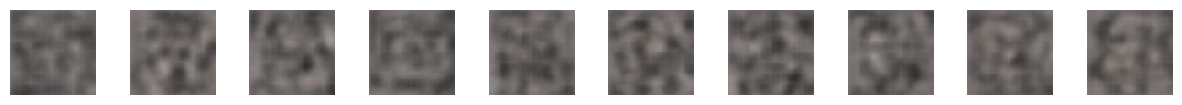

In [19]:
def generate_images_from_noise(n_to_show = 10):
  # For n_to_show images, we create a normal distribution sample on between 0 and 1
  normal_distribution_sample= np.random.normal(0,1,size=(n_to_show,Z_DIM))

  # we apply the decoder part to the samples to see what is generated
  reconst_images = decoder.predict(normal_distribution_sample)

  # Plots the figures
  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')
      sub.imshow(img)

generate_images_from_noise()

Comme nous pouvons le constater, le decoder n'est pas capable, à partir du latent space de générer une image.    

**La raison est la suivante :** l'espace latent dans un autoencodeur est souvent de dimension réduite par rapport à l'espace d'entrée. La conséquence est que plusieurs images d'entrées peuvent être projetées sur la même région de l'espace latent (Cf. par exemple les points qui se superposent dans les figures précédentes). Il n'est donc pas possible de générer de nouvelles images uniquement à partir de l'espace latent car plusieurs images peuvent correspondrent au même point. Même si l'espace latent est continu, il n'est pas garanti que n'importe quel point de cet espace puisse être décodé de manière significative en une image reconnaissable (elles ne correspondent pas à des images d'entrées). Enfin l'espace latent d'un autoencoder ne tient pas compte de la structuration des données d'origines. Considérons par exemple le cas des 2. Nous voyons qu'ils peuvent être répartis partout dans l'espace plutôt que d'être regroupés et qu'un 2 est sans doute plus proche d'un 8, 9 ou 0 que d'un 1. Pour résumer, le problème vient du fait que l'objectif de l'autoencoder est de réduire les dimensions (le principe est très proche des CNN) et non pas de tenir compte de la distribution des données dans l'espace.   

Pour finir, nous affichons, pour cinq images, leur latent space associé.

1/1 [==============================] - 0s 204ms/step


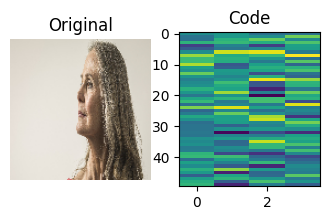

1/1 [==============================] - 0s 17ms/step


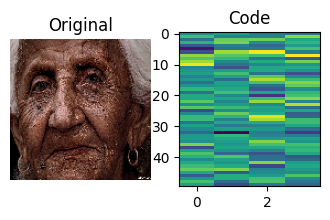

1/1 [==============================] - 0s 18ms/step


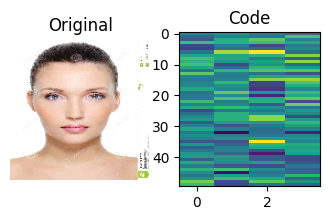

1/1 [==============================] - 0s 20ms/step


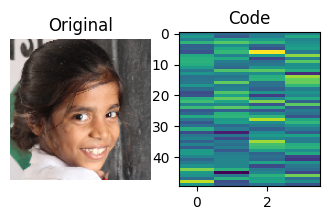

1/1 [==============================] - 0s 18ms/step


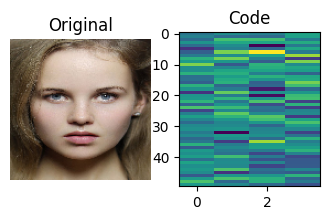

In [20]:
def visualize(img, encoder):
    # img[None] will have a shape of (1, 32, 32, 3), which is the same as the input shape of the model
    code = encoder.predict(img[None])[0]

    fig, axs = plt.subplots(1, 2, figsize=(4, 2))  # Creates a figure with 1 row and 2 columns for subplots
    axs[0].set_title("Original")  # Title for the subplot of the original image
    axs[0].imshow(img)  # Displays the original image
    axs[0].axis('off')  # Turns off axes for the original image

    axs[1].set_title("Code")  # Title for the subplot of the latent space
    axs[1].imshow(code.reshape([code.shape[-1]//4, -1]))  # Displays the latent space
    axs[1].set_aspect('auto')  # Restores automatic aspect ratio for the latent space

    plt.show()  # Displays the figure


for i in range(5):
    img = X_test[i]
    visualize(img, encoder_model)  # Calls the visualize function for each image



####Les variational autoencoder

Alors qu'un auto-encodeur simple apprend à mapper chaque image sur un point fixe dans le latent space, l'encodeur d'un autoencodeur variationnel (VAE) mappe chaque image sur une distribution normale standard à z-dimensions (la taille du latent space). Le principe général est illustrée sur la figure suivante :   

<IMG SRC="http://www.lirmm.fr/~poncelet/Ressources/vae.png" align="center" width="600" height="300">

Le VAE étend l'autoencodeur classique en introduisant une composante probabiliste dans le processus d'encodage (la partie vecteur moyenne et vecteur écart type) afin de mieux considérer la distribution des données. Par rapport aux codes précédents, seul l'encoder est à modifier pour prendre en compte ces modifications.


**Remarque :** TensorFlow a des problèmes lors que l'on modifie la fonction de coût. Il faut exécuter la fonction suivante au début (cf. https://github.com/keras-team/keras/issues/16066).

In [21]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Le début est similaire mais il faut à présent ajouter des couches pour prendre en compte le vecteur moyenne, le vecteur écart type et la partie échantillonage :

In [22]:
# ENCODER VAE
def build_vae_encoder(input_dim, output_dim):
  # By using clear_session we remove all the previous runs. That's a way to re-initialize
  global K
  K.clear_session()

  #  model input
  vae_encoder_input = Input(shape = input_dim, name = 'vae_encoder_input')
  x = vae_encoder_input

  # First convolution
  x= Conv2D(filters = 32,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'vae_encoder_conv_1')(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Second Convolution
  x= Conv2D(filters = 64,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'vae_encoder_conv_2')(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Third Convolution
  x= Conv2D(filters = 64,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'vae_encoder_conv_3')(x)
  # Applying the activation function
  x = LeakyReLU()(x)

   # Fourth Convolution
  x= Conv2D(filters = 64,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'vae_encoder_conv_4')(x)
  # Applying the activation function
  x = LeakyReLU()(x)


  # We need to get the latest shape before applying flatten for the decoder
  shape_before_flattening = K.int_shape(x)[1:]

  # Flatten the last CNN
  x = Flatten()(x)

  # Difference from the previous encoder
  # create a layer for the mean
  mean_mu = Dense(output_dim, name = 'mu')(x)
  # create a layer for the standard deviation
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.)
    return mean_mu + K.exp(log_var/2)*epsilon

  # Using a Keras Lambda Layer to include the sampling function as a layer
  # in the model. This is important for the gradient descent
  vae_encoder_output = Lambda(sampling, name='vae_encoder_output')([mean_mu, log_var])


  return vae_encoder_input, vae_encoder_output, mean_mu, log_var, shape_before_flattening, Model(vae_encoder_input, vae_encoder_output)


Comme précédemment on créé l'encoder du VAE :

In [23]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM,
                                    )

vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_encoder_input (InputLayer)  [(None, 128, 128, 3  0          []                               
                                )]                                                                
                                                                                                  
 vae_encoder_conv_1 (Conv2D)    (None, 64, 64, 32)   896         ['vae_encoder_input[0][0]']      
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['vae_encoder_conv_1[0][0]']     
                                                                                                  
 vae_encoder_conv_2 (Conv2D)    (None, 32, 32, 64)   18496       ['leaky_re_lu[0][0]']        

Le decoder est complètement similaire à celui de l'autoencoder précédent. Dans la colonne suivante, nous renommons juste les variables pour avoir une présentation générale similaire.

In [24]:
# DECODER FOR VAE - SAME THAT FOR AE

def build_vae_decoder(input_dim, shape_before_flattening):
  # Define model input
  vae_decoder_input = Input(shape = (input_dim,) , name = 'vae_decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(vae_decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # First Conv2DTranspose layer
  x = Conv2DTranspose(filters = 64,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'vae_decoder_conv_1'
                  )(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Second Conv2DTranspose layer
  x = Conv2DTranspose(filters = 64,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'vae_decoder_conv_2'
                  )(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Third Conv2DTranspose layer
  x = Conv2DTranspose(filters = 32,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'vae_decoder_conv_3'
                  )(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Fouth Conv2DTranspose layer
  x = Conv2DTranspose(filters = 3,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'vae_decoder_conv_4'
                  )(x)
  # Applying the activation function
  x = Activation('sigmoid')(x)

  vae_decoder_output = x

  return vae_decoder_input, vae_decoder_output, Model(vae_decoder_input, vae_decoder_output)

On créé la partie decoder :

In [25]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_vae_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening
                                        )
vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_encoder_input (InputLayer)  [(None, 128, 128, 3  0          []                               
                                )]                                                                
                                                                                                  
 vae_encoder_conv_1 (Conv2D)    (None, 64, 64, 32)   896         ['vae_encoder_input[0][0]']      
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['vae_encoder_conv_1[0][0]']     
                                                                                                  
 vae_encoder_conv_2 (Conv2D)    (None, 32, 32, 64)   18496       ['leaky_re_lu[0][0]']        

Nous pouvons créer le vae :

In [26]:
vae_autoencoder_input = vae_encoder_input
vae_autoencoder_output = vae_decoder(vae_encoder_output)
vae_autoencoder = Model(vae_autoencoder_input, vae_autoencoder_output)
vae_autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_encoder_input (InputLayer)  [(None, 128, 128, 3  0          []                               
                                )]                                                                
                                                                                                  
 vae_encoder_conv_1 (Conv2D)    (None, 64, 64, 32)   896         ['vae_encoder_input[0][0]']      
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['vae_encoder_conv_1[0][0]']     
                                                                                                  
 vae_encoder_conv_2 (Conv2D)    (None, 32, 32, 64)   18496       ['leaky_re_lu[0][0]']      

Jusqu'à présent nous avons vu que les modifications sont assez simples au niveau de l'encoder et que le decoder n'avait pas besoin d'être modifié. Pour le decoder il faut ajouter une couche pour la moyenne, une pour l'écart type, avoir une fonction qui permet de faire de l'échantillonage sur la distribution et ajouter cette échantillonage dans une couche afin que la descente de gradient puisse être réalisée.   

**Quid de la fonction de coût ?** pour l'autoencoder nous avions vu que nous pouvions prendre MSE - *Mean Square Error* - (nous aurions pu prendre un autre fonction de coût comme comme cross-entropy). Cette fonction permet de mettre à jour les poids dans le modèle. Par contre, à présent, nous avons un autre élément qui doit être mis à jour : bien choisir la distribution pour l'échantillonage !!   

Pour cela il existe la **divergence de Kullback-Leibler (KL)** qui est une mesure de la différence entre deux distributions de probabilité. Elle est souvent utilisée dans le domaine de l'information et de la théorie de l'information pour comparer deux distributions de probabilité et quantifier leur similarité ou leur dissimilarité. Elle mesure à quel point une distribution de probabilité diffère d'une distribution de référence. Pour nous elle peut être utilisée pour mesurer à quel point la distribution de l'échantillon est similaire à celles des images d'entrée. C'est grâce à cela que nous pouvons forcer le latent space à avoir des distributions similaires aux images d'entrée !!!   

Pour finaliser notre VAE il s'agit donc de modifier la fonction de coût pour qu'elle prenne en compte la MSE et la KL divergence.   

La fonction de coût est une somme de MSE et de KL Divergence. Une pondération est attribuée à la perte MSE, connue sous le nom de facteur de perte (*B*). Le facteur de perte est multiplié par la perte MSE. Si nous utilisons un facteur de perte élevé, nous privilégions la MSE et donc nous nous retrouvons comme avec un autoencoder simple. De la même manière si la perte est trop faible, la qualité des images générées sera mauvaise.   

La cellule suivante propose la nouvelle fonction de coût :


In [27]:

B = 10000

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def total_loss(y_true, y_pred):
    return B*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)



Réinitialisation de toutes les variables. Remarque BATCH_SIZE a été diminué par rapport à l'autoencoder car le modèle prend beaucoup en RAM. En diminuant le BATCH_SIZE moins d'images sont générées par ImageDataGenerator.

In [28]:
DATA_FOLDER = "Humans2"
NUM_IMAGES=len(os.listdir(DATA_FOLDER))
EPOCH=25
WEIGHTS_FOLDER = './myweights/'

# Get all the file names with extension .jpg from DATA_FOLDER/train
filenames = np.array(glob(os.path.join(DATA_FOLDER+'/train', '*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 256 # batchsize dimension
Z_DIM = 200 # Dimension of the latent vector

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER,
                                                                  classes=['train'],
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   color_mode='rgb',
                                                                   seed=42,
                                                                   class_mode = 'input'
                                                                   )

# parameters of the model
LEARNING_RATE=.0005
steps_per_epoch=int(NUM_IMAGES / BATCH_SIZE)
EPOCHS=40

Total number of images : 6973
Found 7219 images belonging to 1 classes.


Par la suite, le principe est le même, il suffit de prendre en compte la nouvelle fonction de coût.

**CO2 !!! Remarque IMPORTANTE** Pour gagner du temps (**l'apprentissage est très long**) , éviter de relancer l'apprentissage et du CO2 un modèle appris est disponible. Nous l'utilisons juste après. Si vous voulez le lancer il faut enlever les commentaires dans la cellule ci-dessous.

In [29]:
#vae_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss = total_loss, metrics = [r_loss, kl_loss])
# Generate a validation data
#val_data_flow=next(data_flow)
#checkpoint_vae_autoencoder = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAEweights.h5'), save_weights_only = True, verbose=1)
#history=vae_autoencoder.fit(data_flow,
                      shuffle=True,
                      epochs = EPOCHS,
                      initial_epoch = 0,
                      steps_per_epoch=steps_per_epoch,
                      validation_data=val_data_flow,
                      callbacks=[checkpoint_vae_autoencoder])

RuntimeError: ignored

Télécharger les poids appris :

In [30]:
!wget https://www.lirmm.fr/~poncelet/Ressources/VAEweights.h5

--2023-09-07 21:51:00--  https://www.lirmm.fr/~poncelet/Ressources/VAEweights.h5
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10634096 (10M) [text/plain]
Saving to: ‘VAEweights.h5’

VAEweights.h5       100%[===================>]  10.14M  6.99MB/s    in 1.5s    

2023-09-07 21:51:03 (6.99 MB/s) - ‘VAEweights.h5’ saved [10634096/10634096]



Chargement des poids sauvegardés dans le modèle :

In [31]:
# Load the weights to the model
vae_autoencoder.load_weights('VAEweights.h5')

La cellule suivante affiche des images en utilisant le variational autoencoder. Comme nous pouvons le constater les images sont assez similaires à celles obtenues via un autoencoder. En fait le variational autoencoder permet de comprimer les images mais surtout en prenant en compte la distribution des données d'entrées, permet d'utiliser ce latent space pour générer de nouvelles images qui n'existent pas.

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


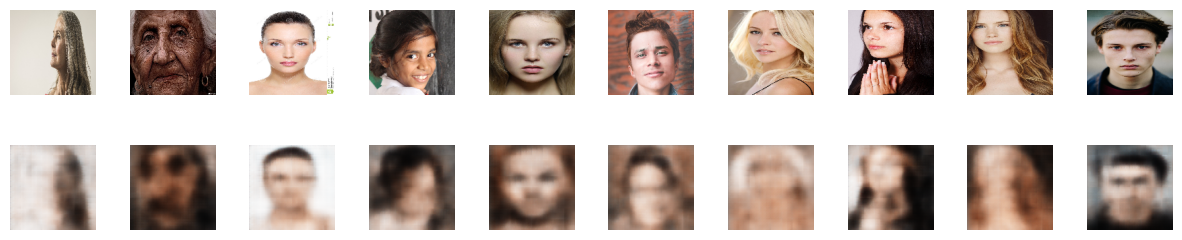

In [32]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]
show_images(vae_autoencoder,example_images)

A présent nous pouvons générer de nouvelles images :

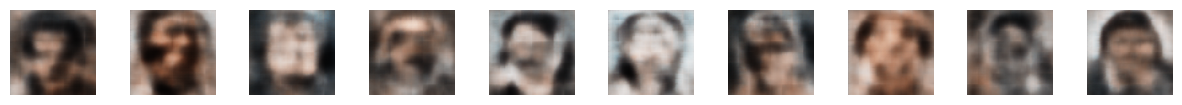

In [33]:
def generate_images_from_noise(n_to_show = 10):
  # For n_to_show images, we create a normal distribution sample on between 0 and 1
  normal_distribution_sample= np.random.normal(0,1,size=(n_to_show,Z_DIM))

  # we apply the decoder part to the samples to see what is generated
  reconst_images = vae_decoder.predict(normal_distribution_sample)

  # Plots the figures
  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')
      sub.imshow(img)

generate_images_from_noise()

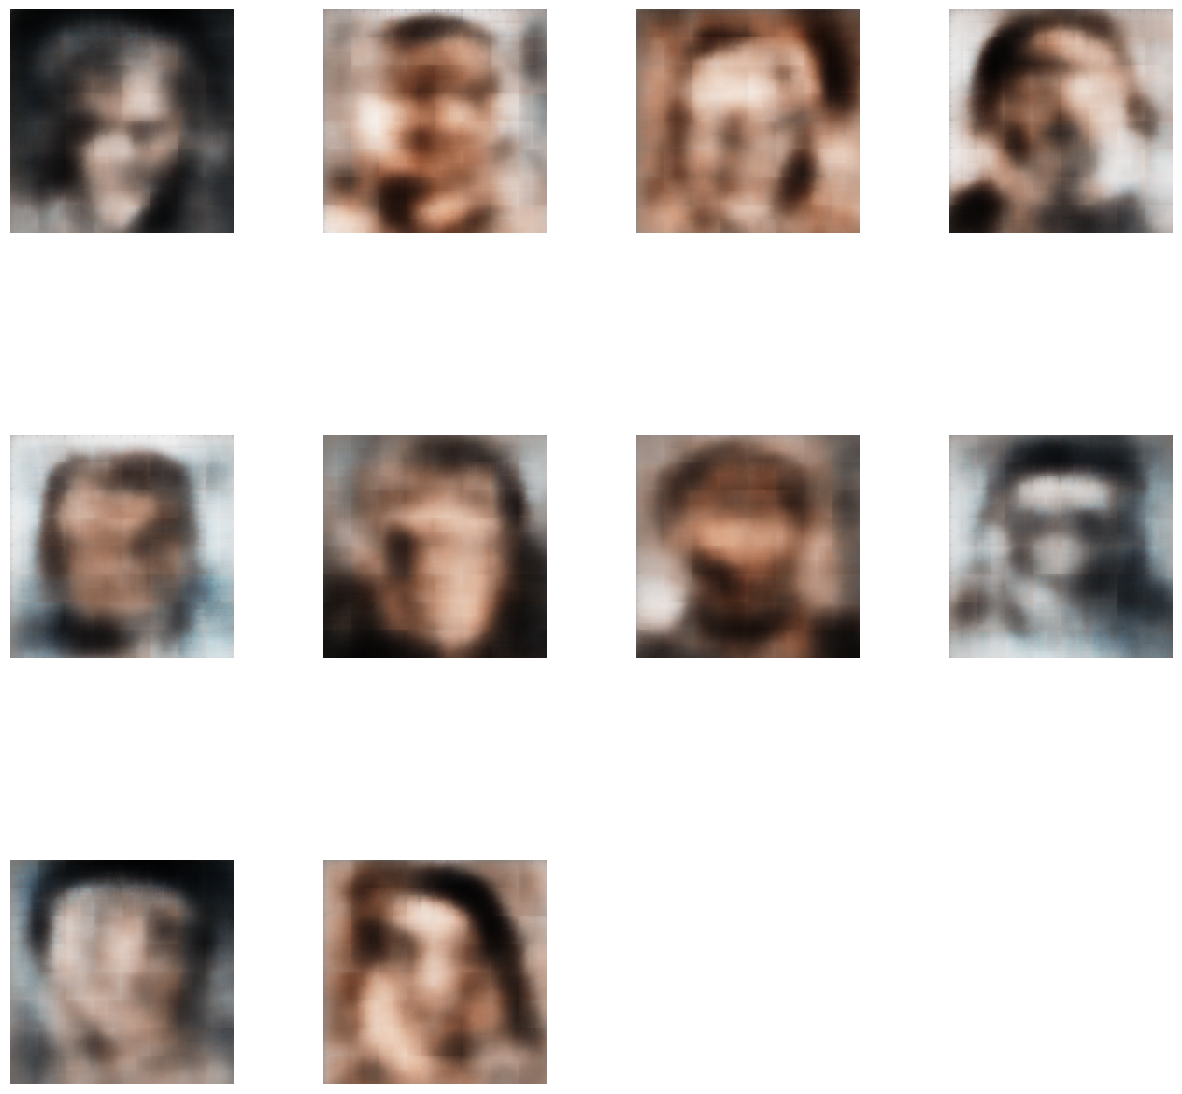

In [34]:
def generate_images_from_noise(n_to_show=10):
    # For n_to_show images, we create a normal distribution sample between 0 and 1
    normal_distribution_sample = np.random.normal(0, 1, size=(n_to_show, Z_DIM))

    # we apply the decoder part to the samples to see what is generated
    reconst_images = vae_decoder.predict(normal_distribution_sample)

    # Plots the figures
    fig = plt.figure(figsize=(15, 15))  # Increase figure size
    rows = int(np.ceil(n_to_show / 4))  # Calculate number of rows needed
    columns = 4  # Set number of columns per row
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(rows, columns, i + 1)  # Update subplot position
        sub.axis('off')
        sub.imshow(img)

generate_images_from_noise()

Enfin, nous pouvons afficher le latent space pour 5 images et nous pouvons constater que le latent space décrit bien la distribution comparativement à l'approche par autoencoder.

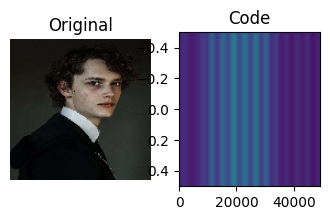

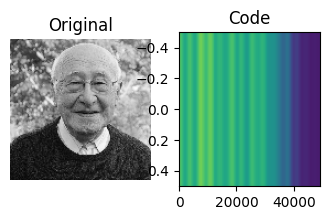

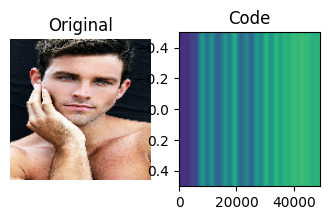

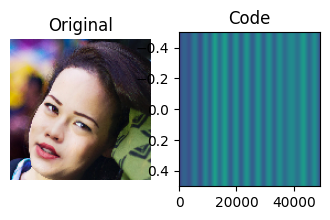

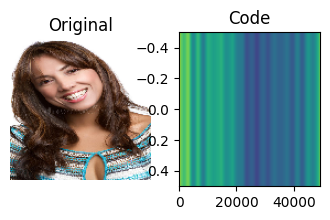

In [35]:
def visualize(img, encoder):
    # img[None] will have a shape of (1, 32, 32, 3), which is the same as the input shape of the model
    code = encoder.predict(img[None])[0]

    fig, axs = plt.subplots(1, 2, figsize=(4, 2))  # Creates a figure with 1 row and 2 columns for subplots
    axs[0].set_title("Original")  # Title for the subplot of the original image
    axs[0].imshow(img)  # Displays the original image
    axs[0].axis('off')  # Turns off axes for the original image

    axs[1].set_title("Code")  # Title for the subplot of the latent space
    axs[1].imshow(code.reshape([code.shape[-1]//2, -1]))  # Displays the latent space
    axs[1].set_aspect('auto')  # Restores automatic aspect ratio for the latent space

    plt.show()  # Displays the figure

# Create a batch as X_test
X_test = next(data_flow)
# Get the corrupted image
X_test = X_test[0]
for i in range(5):
    img = X_test[i]
    visualize(img, vae_autoencoder)  # Calls the visualize function for each image